In [1]:
!git clone https://github.com/rmnigm/qber-forecasting.git

Cloning into 'qber-forecasting'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 35 (delta 9), reused 27 (delta 4), pack-reused 0
Unpacking objects: 100% (35/35), 25.79 MiB | 2.43 MiB/s, done.
Updating files: 100% (9/9), done.


In [2]:
!git clone https://github.com/nkborisov/QBER-LSTM-based-estimation.git

Cloning into 'QBER-LSTM-based-estimation'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 41 (delta 8), reused 36 (delta 6), pack-reused 0
Unpacking objects: 100% (41/41), 12.57 MiB | 1.83 MiB/s, done.


In [3]:
import numpy as np
import pandas as pd
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [4]:
class ExponentionalAverager:
    def __init__(self, start_value, window_size):
        assert window_size >= 0
        self.val = start_value
        self.alpha = 2. / (window_size + 1)
        self.window_size = window_size

    def update(self, val):
        self.val = self.alpha * val + (1. - self.alpha) * self.val

    def get(self):
        return self.val

In [5]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

In [6]:
set_random_seed(77)
print(f'CUDA = {torch.cuda.is_available()}')

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

CUDA = False


In [7]:
class TorchTSDataset(Dataset):
    def __init__(self, dataset, look_back=1, device='cpu'):
        length = dataset.shape[0] - look_back - 1
        width = dataset.shape[1]
        X, y = np.empty((length, look_back, width)), np.empty((length, 1))
        for i in range(length):
            X[i] = dataset[i:(i + look_back), :]
            y[i] = dataset[i + look_back, 0]
        self.X = torch.tensor(X).float().to(device)
        self.y = torch.tensor(y).float().to(device)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
pulses_stats_file_path = "/content/QBER-LSTM-based-estimation/dataset/fr_gains.csv"
dataframe = pd.read_csv(pulses_stats_file_path, usecols=[0, 1, 2, 3, 4, 5, 6], engine='python')
dataset = dataframe.values.astype('float32')

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
X_train, X_test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Training set size = {}, testing set size = {}".format(train_size, test_size))


look_back = 4
train_set = TorchTSDataset(X_train, look_back)
train_loader = DataLoader(train_set, batch_size = 1024, shuffle = False)

test_set = TorchTSDataset(X_test, look_back)
test_loader = DataLoader(test_set, batch_size = 1024, shuffle = False)

criterion = nn.MSELoss()

Training set size = 147879, testing set size = 36970


In [11]:
def train(model, optimizer, criterion, train_loader):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
    '''
    train_losses = []
    test_losses = []
    
    model.train()

    for X, y in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        predicts = model(X)
        loss = criterion(y, predicts)
        train_losses.append(float(loss))
        loss.backward()
        optimizer.step()
    
    return np.array(train_losses)


def test_eval(model, criterion, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    cumulative_error = 0
    cumulative_mape = 0
    
    model.eval()
    for X, y_true in tqdm.tqdm(test_loader):
        y_pred = model(X)

        y_pred = y_pred.detach().numpy()
        y_true = y_true.detach().numpy()

        loss = mean_squared_error(y_pred, y_true, squared = True)
        mape = mean_absolute_percentage_error(y_pred, y_true)

        cumulative_error += loss * len(y_true)
        cumulative_mape += mape * len(y_true)

    mse = (cumulative_error / len(test_loader.dataset.y)) ** 0.5
    mape = (cumulative_mape / len(test_loader.dataset.y))
    return mse, mape

In [12]:
class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        tensor, _ = x
        # Reshape shape (batch, hidden)
        return tensor[:, -1, :]

In [23]:
input_size = 7
output_size = 1
hidden_size = 128


model = nn.Sequential(
    nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True),
    extract_tensor(),
    nn.Linear(hidden_size * 2, output_size)
    ).to(device)

In [24]:
num_epochs = 10
train_losses = []
test_losses = []

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)


for epoch in range(num_epochs):
    print('Training')
    train(model, optimizer, criterion, train_loader)

    print('Train Evaluation')
    train_mse, train_mape = test_eval(model, criterion, train_loader)
    train_losses.append((train_mse, train_mape))

    print('Test Evaluation')
    test_mse, test_mape = test_eval(model, criterion, test_loader)
    test_losses.append((test_mse, test_mape))

    print('Epoch ', epoch)
    print(f'Train MSE: {train_mse}, Train MAPE: {train_mape}')
    print(f'Test MSE: {test_mse}, Test MAPE: {test_mape}')

Training


100%|██████████| 145/145 [00:26<00:00,  5.57it/s]


Train Evaluation


100%|██████████| 145/145 [00:08<00:00, 17.12it/s]


Test Evaluation


100%|██████████| 37/37 [00:02<00:00, 14.71it/s]


Epoch  0
Train MSE: 0.009776734475493494, Train MAPE: 0.1984710869913255
Test MSE: 0.009496499946221057, Test MAPE: 0.17159414014562482
Training


100%|██████████| 145/145 [00:24<00:00,  5.96it/s]


Train Evaluation


100%|██████████| 145/145 [00:09<00:00, 14.68it/s]


Test Evaluation


100%|██████████| 37/37 [00:02<00:00, 17.77it/s]


Epoch  1
Train MSE: 0.00960258315960768, Train MAPE: 0.18722686349711973
Test MSE: 0.009470840689901103, Test MAPE: 0.16976450877358623
Training


100%|██████████| 145/145 [00:24<00:00,  6.04it/s]


Train Evaluation


100%|██████████| 145/145 [00:09<00:00, 14.79it/s]


Test Evaluation


100%|██████████| 37/37 [00:02<00:00, 15.64it/s]


Epoch  2
Train MSE: 0.009496303747099918, Train MAPE: 0.17953772087698688
Test MSE: 0.009447847143208274, Test MAPE: 0.16812228173335964
Training


100%|██████████| 145/145 [00:24<00:00,  6.00it/s]


Train Evaluation


100%|██████████| 145/145 [00:09<00:00, 14.50it/s]


Test Evaluation


100%|██████████| 37/37 [00:02<00:00, 17.66it/s]


Epoch  3
Train MSE: 0.009427707340477088, Train MAPE: 0.1744335485663829
Test MSE: 0.00942682023945066, Test MAPE: 0.1666230512317585
Training


100%|██████████| 145/145 [00:24<00:00,  6.02it/s]


Train Evaluation


100%|██████████| 145/145 [00:09<00:00, 15.12it/s]


Test Evaluation


100%|██████████| 37/37 [00:02<00:00, 16.15it/s]


Epoch  4
Train MSE: 0.009380045911214453, Train MAPE: 0.17098773624626312
Test MSE: 0.009406900653597608, Test MAPE: 0.16519417383424745
Training


100%|██████████| 145/145 [00:24<00:00,  5.84it/s]


Train Evaluation


100%|██████████| 145/145 [00:08<00:00, 16.46it/s]


Test Evaluation


100%|██████████| 37/37 [00:03<00:00, 11.19it/s]


Epoch  5
Train MSE: 0.009344368501047414, Train MAPE: 0.16857395682489504
Test MSE: 0.009387769243908946, Test MAPE: 0.16381200153869913
Training


100%|██████████| 145/145 [00:23<00:00,  6.18it/s]


Train Evaluation


100%|██████████| 145/145 [00:09<00:00, 14.86it/s]


Test Evaluation


100%|██████████| 37/37 [00:02<00:00, 17.63it/s]


Epoch  6
Train MSE: 0.009315790214384131, Train MAPE: 0.1667960952879585
Test MSE: 0.00936930211608123, Test MAPE: 0.16246823069974467
Training


100%|██████████| 145/145 [00:24<00:00,  5.97it/s]


Train Evaluation


100%|██████████| 145/145 [00:10<00:00, 14.40it/s]


Test Evaluation


100%|██████████| 37/37 [00:02<00:00, 16.92it/s]


Epoch  7
Train MSE: 0.009291582394163634, Train MAPE: 0.16540900412097204
Test MSE: 0.009351449318252816, Test MAPE: 0.1611624523801796
Training


100%|██████████| 145/145 [00:24<00:00,  5.96it/s]


Train Evaluation


100%|██████████| 145/145 [00:09<00:00, 14.62it/s]


Test Evaluation


100%|██████████| 37/37 [00:02<00:00, 17.82it/s]


Epoch  8
Train MSE: 0.009270185073506038, Train MAPE: 0.16426427684179068
Test MSE: 0.00933417805803659, Test MAPE: 0.15989538816425
Training


100%|██████████| 145/145 [00:26<00:00,  5.40it/s]


Train Evaluation


100%|██████████| 145/145 [00:24<00:00,  5.81it/s]


Test Evaluation


100%|██████████| 37/37 [00:02<00:00, 15.87it/s]

Epoch  9
Train MSE: 0.009250677831501622, Train MAPE: 0.16327777681166486
Test MSE: 0.009317453680401181, Test MAPE: 0.15866555288569073


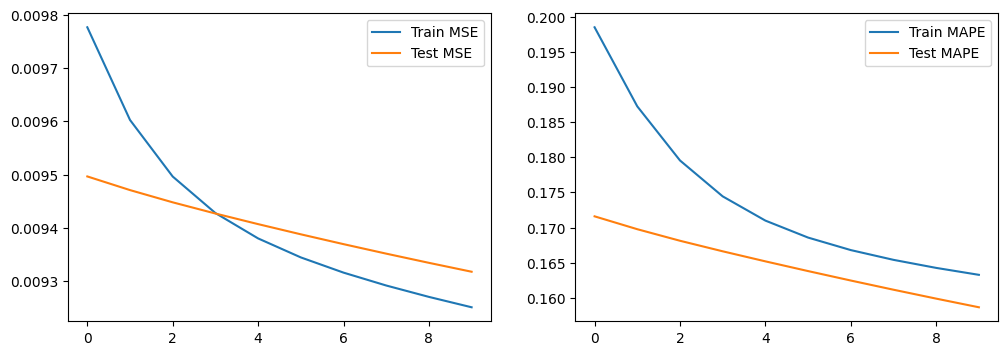

In [25]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)

train_metrics = np.array(train_losses).T
test_metrics = np.array(test_losses).T

sns.lineplot(train_metrics[0], label = 'Train MSE', ax=ax[0])
sns.lineplot(test_metrics[0], label = 'Test MSE', ax=ax[0])
sns.lineplot(train_metrics[1], label = 'Train MAPE', ax=ax[1])
sns.lineplot(test_metrics[1], label = 'Test MAPE', ax=ax[1])
plt.legend()
plt.show()

In [26]:
test_set = TorchTSDataset(X_test, look_back)
test_loader = DataLoader(test_set, batch_size = 1024, shuffle = False)

model.eval()
targets = []
total_preds = []
for batch, target in test_loader:
    targets += list(target.detach().numpy().reshape(-1))
    total_preds += list(model(batch).detach().numpy().reshape(-1))


total_preds_ext = np.zeros((len(total_preds), input_size))
total_preds_ext[:, 0] = total_preds
total_preds = scaler.inverse_transform(total_preds_ext)[:, 0]

targets_ext = np.zeros((len(targets), input_size))
targets_ext[:, 0] = targets
targets = scaler.inverse_transform(targets_ext)[:, 0]


ema = ExponentionalAverager(0.01, 5)
ema_vals = []
for t in targets:
    ema_vals.append(ema.get())
    ema.update(t)

df = pd.DataFrame({'actual': targets,
                   'prediction': total_preds,
                   'exponential_smoothed': ema_vals
                   })
df.reset_index(inplace=True)
df.head(5)

,index,actual,prediction,exponential_smoothed
0,0,0.01162,0.010962,0.010000
1,1,0.01121,0.010766,0.010540
2,2,0.01188,0.011276,0.010763
3,3,0.01235,0.012007,0.011136
4,4,0.01210,0.011470,0.011540


In [27]:
pred_score = mean_squared_error(targets, total_preds, squared=False)
print(f'Model Score: {pred_score:.5f} RMSE')
ema_score = mean_squared_error(targets, ema_vals, squared=False)
print(f'EMA Score: {ema_score:.5f} RMSE')

Model Score: 0.00564 RMSE
EMA Score: 0.00477 RMSE


In [28]:
pred_score = mean_absolute_percentage_error(targets, total_preds)
print(f'Model Score: {pred_score:.5f} MAPE')
ema_score = mean_absolute_percentage_error(targets, ema_vals)
print(f'EMA Score: {ema_score:.5f} MAPE')

Model Score: 0.21861 MAPE
EMA Score: 0.11680 MAPE


In [31]:
fig = px.line(df[:10000], x='index', y=['actual', 'prediction', 'exponential_smoothed'])
fig.show()